In [121]:
#import dependencies
import numpy as np
import pandas as pd
import json
import re

from sqlalchemy import create_engine

from config import db_password
import time

In [122]:
with open(f'{file_dir}/wikipedia.movies.json', mode='r',encoding="utf8") as file:
    wiki_movies_raw = json.load(file)

In [123]:
# wiki_movies_df = pd.json_normalize(wiki_movies_raw)
wiki_movies_df = pd.DataFrame(wiki_movies_raw)
wiki_movies_df.shape

(7311, 193)

In [124]:
wiki_movies = [movie for movie in wiki_movies_raw
               if ('Director' in movie or 'Directed by' in movie)
                   and 'imdb_link' in movie
                   and 'No. of episodes' not in movie]

In [125]:
def clean_movie(movie):
    movie = dict(movie) #create a non-destructive copy
    alt_titles = {}
    # combine alternate titles into one list
    for key in ['Also known as','Arabic','Cantonese','Chinese','French',
                'Hangul','Hebrew','Hepburn','Japanese','Literally',
                'Mandarin','McCune-Reischauer','Original title','Polish',
                'Revised Romanization','Romanized','Russian',
                'Simplified','Traditional','Yiddish']:
        if key in movie:
            alt_titles[key] = movie[key]
            movie.pop(key)
    if len(alt_titles) > 0:
        movie['alt_titles'] = alt_titles

    # merge column names
    def change_column_name(old_name, new_name):
        if old_name in movie:
            movie[new_name] = movie.pop(old_name)
    change_column_name('Adaptation by', 'Writer(s)')
    change_column_name('Country of origin', 'Country')
    change_column_name('Directed by', 'Director')
    change_column_name('Distributed by', 'Distributor')
    change_column_name('Edited by', 'Editor(s)')
    change_column_name('Length', 'Running time')
    change_column_name('Original release', 'Release date')
    change_column_name('Music by', 'Composer(s)')
    change_column_name('Produced by', 'Producer(s)')
    change_column_name('Producer', 'Producer(s)')
    change_column_name('Productioncompanies ', 'Production company(s)')
    change_column_name('Productioncompany ', 'Production company(s)')
    change_column_name('Released', 'Release Date')
    change_column_name('Release Date', 'Release date')
    change_column_name('Screen story by', 'Writer(s)')
    change_column_name('Screenplay by', 'Writer(s)')
    change_column_name('Story by', 'Writer(s)')
    change_column_name('Theme music composer', 'Composer(s)')
    change_column_name('Written by', 'Writer(s)')

    return movie

In [126]:
# now have a cleaner data
clean_movies = [clean_movie(movie) for movie in wiki_movies]
wiki_movies_df = pd.DataFrame(clean_movies)
wiki_movies_df.shape

(7076, 40)

In [127]:
wiki_movies_df['imdb_id'] = wiki_movies_df['imdb_link'].str.extract(r'(tt\d{7})')
wiki_movies_df.drop_duplicates(subset='imdb_id', inplace=True)
wiki_movies_df.shape

(7033, 41)

In [128]:
column_cnts = wiki_movies_df.count()
column_cnts

url                       7033
year                      7033
imdb_link                 7033
title                     7032
Based on                  2181
Starring                  6849
Narrated by                281
Cinematography            6342
Release date              7001
Running time              6894
Country                   6797
Language                  6789
Budget                    4738
Box office                5485
Director                  7033
Distributor               6676
Editor(s)                 6485
Composer(s)               6515
Producer(s)               6831
Production company(s)     5355
Writer(s)                 6834
Genre                      110
Original language(s)       158
Original network           125
Executive producer(s)       97
Production location(s)      47
Picture format              64
Audio format                61
Voices of                    2
Followed by                  9
Created by                  10
Preceded by                 10
Suggeste

In [129]:
min_cnt = 0.1 * len(wiki_movies_df)
wiki_columns_keep = [col for (col, cnt) in zip(column_cnts.index, column_cnts.tolist()) if (cnt >= min_cnt)]
wiki_movies_df = wiki_movies_df[wiki_columns_keep]
wiki_movies_df.shape

(7033, 21)

In [130]:
wiki_movies_df["Box office"].count()

5485

In [131]:
box_office = wiki_movies_df['Box office'].dropna()

In [132]:
box_office = box_office.apply(lambda x: ' '.join(x) if type(x) == list else x)

In [133]:
box_office.count()

5485

In [134]:
box_office[box_office.map(lambda x: type(x) != str)]
box_office.count()

5485

In [135]:
# mis-spelled as millon or billon, make it optional and take it.
form_one = r'\$\s*\d+\.?\d*\s*[mb]illi?on'

In [136]:
form_two = r'\$\s*\d{1,3}(?:[,\.]\d{3})+(?!\s[mb]illion)'

In [137]:
box_office = box_office.str.replace(r'\$.*[-—–](?![a-z])', '$', regex=True)
box_office.count()

5485

In [138]:
def parse_dollars(s):
    # if s is not a string, return NaN
    if type(s) != str:
        return np.nan

    # if input is of the form $###.# million
    if re.match(r'\$\s*\d+\.?\d*\s*milli?on', s, flags=re.IGNORECASE):

        # remove dollar sign and " million"
        s = re.sub('\$|\s|[a-zA-Z]','', s)

        # convert to float and multiply by a million
        value = float(s) * 10**6

        # return value
        return value

    # if input is of the form $###.# billion
    elif re.match(r'\$\s*\d+\.?\d*\s*billi?on', s, flags=re.IGNORECASE):

        # remove dollar sign and " billion"
        s = re.sub('\$|\s|[a-zA-Z]','', s)

        # convert to float and multiply by a billion
        value = float(s) * 10**9

        # return value
        return value

    # if input is of the form $###,###,###
    elif re.match(r'\$\s*\d{1,3}(?:[,\.]\d{3})+(?!\s[mb]illion)', s, flags=re.IGNORECASE):

        # remove dollar sign and commas
        s = re.sub('\$|,','', s)

        # convert to float
        value = float(s)

        # return value
        return value

    # otherwise, return NaN
    else:
        return np.nan

In [139]:
wiki_movies_df['box_office'] = box_office.str.extract(f'({form_one}|{form_two})', flags=re.IGNORECASE)[0].apply(parse_dollars)

In [140]:
wiki_movies_df.drop('Box office', axis=1, inplace=True)
wiki_movies_df.shape

(7033, 21)

In [141]:
budget = wiki_movies_df['Budget'].dropna()
budget.count()

4738

In [142]:
budget = budget.map(lambda x: ' '.join(x) if type(x) == list else x)
budget = budget.str.replace(r'\$.*[-—–](?![a-z])', '$', regex=True)
budget.count()

4738

In [143]:
matches_form_one = budget.str.contains(form_one, flags=re.IGNORECASE)
matches_form_two = budget.str.contains(form_two, flags=re.IGNORECASE)
budget[~matches_form_one & ~matches_form_two]

136                         Unknown
204     60 million Norwegian Kroner
478                         Unknown
973             $34 [3] [4] million
1126               $120 [4] million
1226                        Unknown
1278                            HBO
1374                     £6,000,000
1397                     13 million
1480                   £2.8 million
1734                   CAD2,000,000
1913     PHP 85 million (estimated)
1948                    102,888,900
1953                   3,500,000 DM
1973                     ₤2,300,874
2281                     $14 milion
2451                     ₤6,350,000
3144                   € 40 million
3360               $150 [6] million
3418                        $218.32
3802                   £4.2 million
3906                            N/A
3959                    760,000 USD
4470                       19 crore
4641                    £17 million
5034              $$200 [4] million
5055           $155 [2] [3] million
5419                $40 [4] 

In [144]:
budget = budget.str.replace(r'\[\d+\]\s*', '')
budget[~matches_form_one & ~matches_form_two]

136                         Unknown
204     60 million Norwegian Kroner
478                         Unknown
973                     $34 million
1126                   $120 million
1226                        Unknown
1278                            HBO
1374                     £6,000,000
1397                     13 million
1480                   £2.8 million
1734                   CAD2,000,000
1913     PHP 85 million (estimated)
1948                    102,888,900
1953                   3,500,000 DM
1973                     ₤2,300,874
2281                     $14 milion
2451                     ₤6,350,000
3144                   € 40 million
3360                   $150 million
3418                        $218.32
3802                   £4.2 million
3906                            N/A
3959                    760,000 USD
4470                       19 crore
4641                    £17 million
5034                  $$200 million
5055                   $155 million
5419                    $40 

In [145]:
wiki_movies_df['budget'] = budget.str.extract(f'({form_one}|{form_two})', flags=re.IGNORECASE)[0].apply(parse_dollars)

In [146]:
wiki_movies_df.drop('Budget', axis=1, inplace=True)

In [147]:
release_date = wiki_movies_df['Release date'].dropna().apply(lambda x: ' '.join(x) if type(x) == list else x)

In [148]:
date_form_one = r'(?:January|February|March|April|May|June|July|August|September|October|November|December)\s[123]\d,\s\d{4}'
date_form_two = r'\d{4}.[01]\d.[123]\d'
date_form_three = r'(?:January|February|March|April|May|June|July|August|September|October|November|December)\s\d{4}'
date_form_four = r'\d{4}'
release_date.str.extract(f'({date_form_one}|{date_form_two}|{date_form_three}|{date_form_four})', flags=re.IGNORECASE)

,0
0,"July 11, 1990"
1,"May 17, 1990"
2,"August 10, 1990"
3,"December 25, 1990"
4,"December 19, 1990"
...,...
7071,"December 25, 2018"
7072,"December 11, 2018"
7073,2018
7074,"August 31, 2018"


In [149]:
wiki_movies_df['release_date'] = pd.to_datetime(release_date.str.extract(f'({date_form_one}|{date_form_two}|{date_form_three}|{date_form_four})')[0], infer_datetime_format=True)

In [150]:
wiki_movies_df.drop('Release date', axis=1, inplace=True)

In [151]:
running_time = wiki_movies_df['Running time'].dropna().apply(lambda x: ' '.join(x) if type(x) == list else x)

In [152]:
running_time.str.contains(r'^\d*\s*minutes$', flags=re.IGNORECASE).sum()

6528

In [153]:
running_time[running_time.str.contains(r'^\d*\s*minutes$', flags=re.IGNORECASE) != True]

9                                                 102 min
26                                                 93 min
28                                                32 min.
34                                                101 min
35                                                 97 min
                              ...                        
6500       114 minutes [1] 120 minutes (extended edition)
6643                                             104 mins
6709    90 minutes (theatrical) [1] 91 minutes (unrate...
7057    108 minutes (Original cut) 98 minutes (UK cut)...
7075                Variable; 90 minutes for default path
Name: Running time, Length: 366, dtype: object

In [154]:
running_time.str.contains(r'^\d*\s*m', flags=re.IGNORECASE).sum()

6877

In [155]:
running_time_extract = running_time.str.extract(r'(\d+)\s*ho?u?r?s?\s*(\d*)|(\d+)\s*m')
running_time_extract

,0,1,2
0,NaN,NaN,102
1,NaN,NaN,114
2,NaN,NaN,113
3,NaN,NaN,106
4,NaN,NaN,95
...,...,...,...
7071,NaN,NaN,90
7072,NaN,NaN,132
7073,NaN,NaN,120
7074,NaN,NaN,123


In [156]:
running_time_extract = running_time_extract.apply(lambda col: pd.to_numeric(col, errors='coerce')).fillna(0)
running_time_extract.head()

,0,1,2
0,0.0,0.0,102.0
1,0.0,0.0,114.0
2,0.0,0.0,113.0
3,0.0,0.0,106.0
4,0.0,0.0,95.0


In [157]:
wiki_movies_df['running_time'] = running_time_extract.apply(lambda row: row[0]*60 + row[1] if row[2] == 0 else row[2], axis=1)
wiki_movies_df['running_time']

0       102.0
1       114.0
2       113.0
3       106.0
4        95.0
        ...  
7071     90.0
7072    132.0
7073    120.0
7074    123.0
7075     90.0
Name: running_time, Length: 7033, dtype: float64

In [158]:
wiki_movies_df.drop('Running time', axis=1, inplace=True)

In [159]:
wiki_movies_df.shape

(7033, 21)

In [160]:
wiki_movies_df.head(2)

,url,year,imdb_link,title,Based on,Starring,Cinematography,Country,Language,Director,...,Editor(s),Composer(s),Producer(s),Production company(s),Writer(s),imdb_id,box_office,budget,release_date,running_time
0,https://en.wikipedia.org/wiki/The_Adventures_o...,1990,https://www.imdb.com/title/tt0098987/,The Adventures of Ford Fairlane,"[Characters, by Rex Weiner]","[Andrew Dice Clay, Wayne Newton, Priscilla Pre...",Oliver Wood,United States,English,Renny Harlin,...,Michael Tronick,"[Cliff Eidelman, Yello]","[Steve Perry, Joel Silver]",Silver Pictures,"[David Arnott, James Cappe]",tt0098987,21400000.0,20000000.0,1990-07-11,102.0
1,"https://en.wikipedia.org/wiki/After_Dark,_My_S...",1990,https://www.imdb.com/title/tt0098994/,"After Dark, My Sweet","[the novel, After Dark, My Sweet, by, Jim Thom...","[Jason Patric, Rachel Ward, Bruce Dern, George...",Mark Plummer,United States,English,James Foley,...,Howard E. Smith,Maurice Jarre,"[Ric Kidney, Robert Redlin]",Avenue Pictures,"[James Foley, Robert Redlin]",tt0098994,2700000.0,6000000.0,1990-05-17,114.0


In [161]:
wiki_movies_df.columns.to_list()

['url',
 'year',
 'imdb_link',
 'title',
 'Based on',
 'Starring',
 'Cinematography',
 'Country',
 'Language',
 'Director',
 'Distributor',
 'Editor(s)',
 'Composer(s)',
 'Producer(s)',
 'Production company(s)',
 'Writer(s)',
 'imdb_id',
 'box_office',
 'budget',
 'release_date',
 'running_time']

In [162]:
wiki_movies_df['Distributor'].head()

0      20th Century Fox
1       Avenue Pictures
2      TriStar Pictures
3        Orion Pictures
4    Paramount Pictures
Name: Distributor, dtype: object

In [163]:
#put movie data in DFs
kaggle_metadata = pd.read_csv(f'{file_dir}/movies_metadata.csv')
ratings = pd.read_csv(f'{file_dir}/ratings.csv')

C:\Users\laura\Anaconda3\envs\PythonData\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [164]:
kaggle_metadata.shape

(45466, 24)

In [165]:
ratings.shape

(1048575, 4)

In [166]:
kaggle_metadata = kaggle_metadata[kaggle_metadata['adult'] == 'False'].drop('adult',axis='columns')

In [167]:
movies_df = pd.merge(wiki_movies_df, kaggle_metadata, on='imdb_id', suffixes=['_wiki','_kaggle'])
movies_df.columns.to_list()

['url',
 'year',
 'imdb_link',
 'title_wiki',
 'Based on',
 'Starring',
 'Cinematography',
 'Country',
 'Language',
 'Director',
 'Distributor',
 'Editor(s)',
 'Composer(s)',
 'Producer(s)',
 'Production company(s)',
 'Writer(s)',
 'imdb_id',
 'box_office',
 'budget_wiki',
 'release_date_wiki',
 'running_time',
 'belongs_to_collection',
 'budget_kaggle',
 'genres',
 'homepage',
 'id',
 'original_language',
 'original_title',
 'overview',
 'popularity',
 'poster_path',
 'production_companies',
 'production_countries',
 'release_date_kaggle',
 'revenue',
 'runtime',
 'spoken_languages',
 'status',
 'tagline',
 'title_kaggle',
 'video',
 'vote_average',
 'vote_count']

In [168]:
kaggle_metadata.columns.to_list()

['belongs_to_collection',
 'budget',
 'genres',
 'homepage',
 'id',
 'imdb_id',
 'original_language',
 'original_title',
 'overview',
 'popularity',
 'poster_path',
 'production_companies',
 'production_countries',
 'release_date',
 'revenue',
 'runtime',
 'spoken_languages',
 'status',
 'tagline',
 'title',
 'video',
 'vote_average',
 'vote_count']

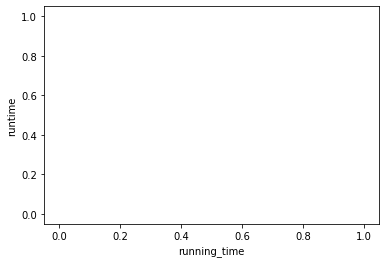

In [169]:
movies_df.fillna(0).plot(x='running_time', y='runtime', kind='scatter')

In [170]:
movies_df.drop(columns=['title_wiki','release_date_wiki','Language','Production company(s)'], inplace=True)

In [171]:
def fill_missing_kaggle_data(df, kaggle_column, wiki_column):
    df[kaggle_column] = df.apply(
        lambda row: row[wiki_column] if row[kaggle_column] == 0 else row[kaggle_column]
        , axis=1)
    df.drop(columns=wiki_column, inplace=True)

In [172]:
fill_missing_kaggle_data(movies_df, 'runtime', 'running_time')
fill_missing_kaggle_data(movies_df, 'budget_kaggle', 'budget_wiki')
fill_missing_kaggle_data(movies_df, 'revenue', 'box_office')
movies_df

,url,year,imdb_link,Based on,Starring,Cinematography,Country,Director,Distributor,Editor(s),...,release_date_kaggle,revenue,runtime,spoken_languages,status,tagline,title_kaggle,video,vote_average,vote_count


In [173]:
for col in movies_df.columns:
    lists_to_tuples = lambda x: tuple(x) if type(x) == list else x
    value_counts = movies_df[col].apply(lists_to_tuples).value_counts(dropna=False)
    num_values = len(value_counts)
    if num_values == 1:
        print(col)

In [174]:
rating_counts = ratings.groupby(['movieId','rating'], as_index=False).count() \
                .rename({'userId':'count'}, axis=1)

In [175]:
rating_counts = ratings.groupby(['movieId','rating'], as_index=False).count() \
                .rename({'userId':'count'}, axis=1) \
                .pivot(index='movieId',columns='rating', values='count')

In [183]:
rating_counts.head()

rating,0.5,1.0,1.5,2.0,2.5,3.0,3.5,4.0,4.5,5.0
movieId,,,,,,,,,,
1,14.0,29.0,11.0,88.0,75.0,469.0,221.0,899.0,235.0,640.0
2,18.0,27.0,11.0,101.0,88.0,351.0,124.0,229.0,25.0,73.0
3,11.0,20.0,13.0,60.0,21.0,247.0,43.0,109.0,7.0,62.0
4,2.0,9.0,3.0,21.0,2.0,43.0,2.0,16.0,1.0,8.0
5,12.0,29.0,10.0,69.0,33.0,251.0,40.0,116.0,4.0,55.0


In [189]:
rows_imported = 0
# get the start_time from time.time()
start_time = time.time()
for data in pd.read_csv(f'{ratings_file}', chunksize=1000000):
    print(f'importing rows {rows_imported} to {rows_imported + len(data)}...', end='')
    if (rows_imported == 0):
        data.to_sql(name='ratings', con=engine, if_exists='replace')
    elif (rows_imported <= 1000000):
        data.to_sql(name='ratings', con=engine, if_exists='append')
    else:
#       data.to_sql(name='ratings', con=engine, if_exists='append')
        pass
    rows_imported += len(data)

    # add elapsed time to final print out
    print(f'Done. {time.time() - start_time:.2f} total seconds elapsed')

NameError: name 'ratings_file' is not defined